# Defacing pre-registration - Statistical analysis in R

## Load simulated data

In [114]:
df_full <- readRDS(file="SimulatedDefacedRatings_noMissing.Rda")
df_missing <- readRDS(file="SimulatedDefacedRatings_10%Missing.Rda")

#Define the number of raters in the dataset
n_rater = length(unique(df$rater))

The simulated data were generated by running the `SimulateDefacedRatings.ipnyb` notebook.

## Linear mixed effect regression

Because the continuation ratio model implementation could not deal with missing values, we are switching to linear mixed effect regression model. It has been shown that considering linear regression on ordinal data is ok, as long as the probabilities of belonging to each category are far from the extremes.

In [115]:
library(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (1 | rater), data=df_full)
summary(fm1)
ranef(fm1)

Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(ratings) ~ defaced + (1 | rater)
   Data: df_full

REML criterion at convergence: 41931.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8718 -0.7702  0.1403  1.0063  1.5259 

Random effects:
 Groups   Name        Variance Std.Dev.
 rater    (Intercept) 0.01502  0.1226  
 Residual             1.18701  1.0895  
Number of obs: 13920, groups:  rater, 12

Fixed effects:
               Estimate Std. Error t value
(Intercept)     2.49397    0.03771   66.13
defaceddefaced  0.33937    0.01847   18.38

Correlation of Fixed Effects:
            (Intr)
defaceddfcd -0.245

$rater
         (Intercept)
rater01 -0.103171623
rater02 -0.156438850
rater03 -0.136261870
rater04 -0.101557465
rater05  0.005784068
rater06 -0.038605288
rater07 -0.008743358
rater08  0.070350403
rater09  0.013854859
rater10  0.051787581
rater11  0.197061836
rater12  0.205939707

with conditional variances for “rater” 

### Do I need interaction terms in my model ?

We use an interaction plot to figure if an interaction between the defacing status and the rater is present. If the lines are not parallel, an interaction exists. Plot construction based on https://stattrek.com/multiple-regression/interaction.

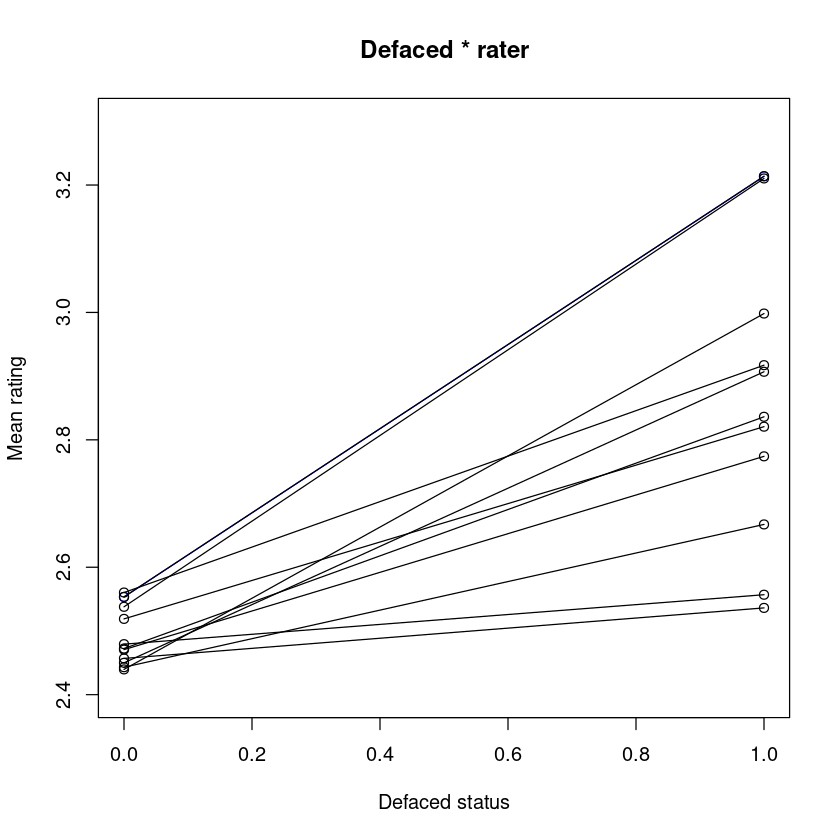

In [116]:
#Compute mean rating for each rater and each condition
mean_defaced = c()
mean_original = c()
for (i in 1:n_rater){
    df_small_defaced <- subset(df_full, defaced == 'defaced' & rater == sprintf('rater%02d', i))
    df_small_original <- subset(df_full, defaced == 'original' & rater == sprintf('rater%02d', i))
    mean_defaced[i] <- mean(as.numeric(df_small_defaced$ratings))
    mean_original[i] <- mean(as.numeric(df_small_original$ratings))
}

#Interaction plot
plot(c(0,1), c(mean_original[i], mean_defaced[i]),
    ylab="Mean rating",
    xlab="Defaced status",
    main ='Defaced * rater',
    ylim = c(2.4,3.3),
    type="o",
    col="blue")
for (i in 2:n_rater){ 
    lines(c(0,1), c(mean_original[i], mean_defaced[i]), type='o')
}

In the plot above, one line represents the evolution of the mean rating before and after defacing for one rater. The lines are not parallel, so we have to include the interaction term into the model. I interpret it as different raters are differently biased by the defacing process.
BUT I doubt adding the interaction term is a good idea, because adding the interaction term requires to estimate a lot of parameters.

### How to deal with missing values

List the different options available to deal with missing values.

In [117]:
getOption("na.action")

[1] "na.omit"

In [124]:
library(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (1 | rater), data=df_missing, na.action=na.exclude)
summary(fm1)
ranef(fm1)

Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(ratings) ~ defaced + (1 | rater)
   Data: df_missing

REML criterion at convergence: 37612.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8970 -0.7832  0.1393  1.0253  1.5075 

Random effects:
 Groups   Name        Variance Std.Dev.
 rater    (Intercept) 0.009632 0.09814 
 Residual             1.175285 1.08411 
Number of obs: 12528, groups:  rater, 12

Fixed effects:
               Estimate Std. Error t value
(Intercept)     2.49777    0.03147   79.37
defaceddefaced  0.34355    0.01937   17.73

Correlation of Fixed Effects:
            (Intr)
defaceddfcd -0.308

$rater
         (Intercept)
rater01 -0.132072872
rater02 -0.119208631
rater03 -0.040307954
rater04 -0.066036436
rater05 -0.018009937
rater06 -0.014579473
rater07  0.017152321
rater08  0.007718544
rater09  0.047168883
rater10  0.016294705
rater11  0.086619221
rater12  0.215261629

with conditional variances for “rater” 